# Topic: Research Papers Classification 


Research Papers Classification comprises of six labels i.e., Computer Science, Physics, Mathematics, Statistics, Quantitative Biology, Quantitative Finance with approximately 30,000 records

I am building the classification using **LSTM** using **Keras python library** with below two variation :
- Model without pre-trained word embedding/with pre-trained word embedding using GloVe(glove.6B.100d.txt).
- Model with two optimizers i,e Adam & SGD with the pre-trained word embedding and comparison between them.

To evaluate and test the model, i have constructed the *' confusion matrix '* along with *' loss vs epoch and accuracy vs epoch '* plots

Finally, i am testing the saved model against the unseen data which is in test.csv.

# Step 1: Data Visualization


In this step i am checking for null values, distribution of labels and balance of the data across the labels

In [1]:
#importing all the dependencies
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Path of the :
- Test and Train data
- GloVe embedding file 
- Saved model

**change the path to run the experiement in your local**

In [2]:
train_respapers = pd.read_csv('../NLPCourseWork/ResearchPapersDataset/train.csv')
test_respapers = pd.read_csv('../NLPCourseWork/ResearchPapersDataset/test.csv')
modelpath_withoutPretrainEmb="..\\NLPCourseWork\\ModelWithoutPretrainEmb.hdf5"
modelpath_withPretrainEmb="..\\NLPCourseWork\\ModelWithPretrainEmb.hdf5"
glovepath_file='..\\NLPCourseWork\\glove.6B.100d.txt'

In [3]:
print("Number of rows in data =",train_respapers.shape[0])
print("Number of columns in data =",train_respapers.shape[1])
print("\n")
print("**Sample data:**")
train_respapers.head()

Number of rows in data = 20972
Number of columns in data = 9


**Sample data:**


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
#check for missing values
missing_values_check = train_respapers.isnull().sum()
print("Check for Missing values:\n ")
print(missing_values_check)

Check for Missing values:
 
ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64


There are no any null or missing values in data and all the labels are tagged to data

In [5]:
#Check for the Papers without labels
rowSums = train_respapers.iloc[:,3:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of papers = ",len(train_respapers))
print("Number of papers with labels =",(len(train_respapers)-clean_comments_count))

Total number of papers =  20972
Number of papers with labels = 20972


In [6]:
#print the list of Target labels
categories = list(train_respapers.columns.values)
categories = categories[3:]
print("List of Labels: ",categories)

List of Labels:  ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']


In [7]:
# Calculating number of research papers in each category
counts = []
for category in categories:
    counts.append((category, train_respapers[category].sum()))
df_stats = pd.DataFrame(counts, columns=['Research Category', 'Number of Papers'])
print(df_stats)

      Research Category  Number of Papers
0      Computer Science              8594
1               Physics              6013
2           Mathematics              5618
3            Statistics              5206
4  Quantitative Biology               587
5  Quantitative Finance               249


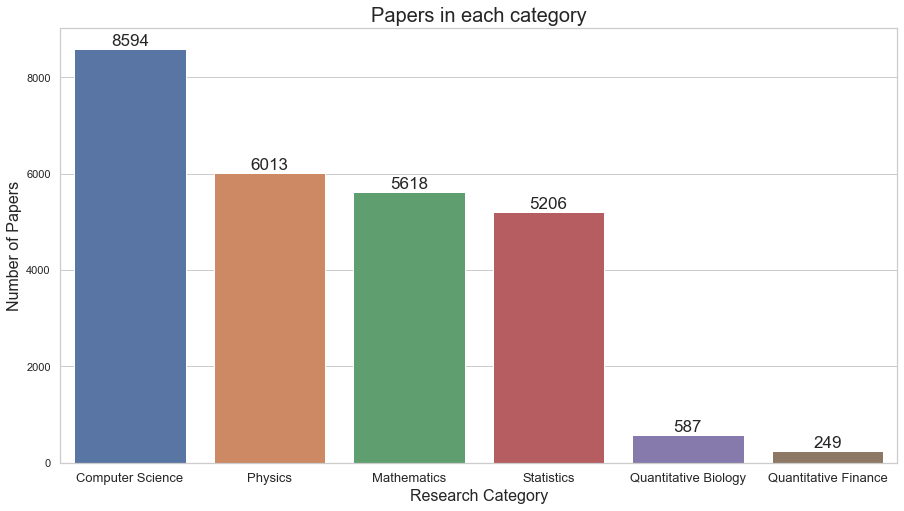

In [8]:

plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax= sns.barplot(x=categories, y=train_respapers.iloc[:,3:].sum().values)

plt.title("Papers in each category", fontsize=20)
plt.ylabel('Number of Papers', fontsize=16)
plt.xlabel('Research Category', fontsize=16)

#adding the text labels
rects = ax.patches
labels = train_respapers.iloc[:,3:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=17)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
plt.show()

The data is very imbalanced with only 587 records with "Quantitative Biology" and 249 records with "Quantitative Finance"

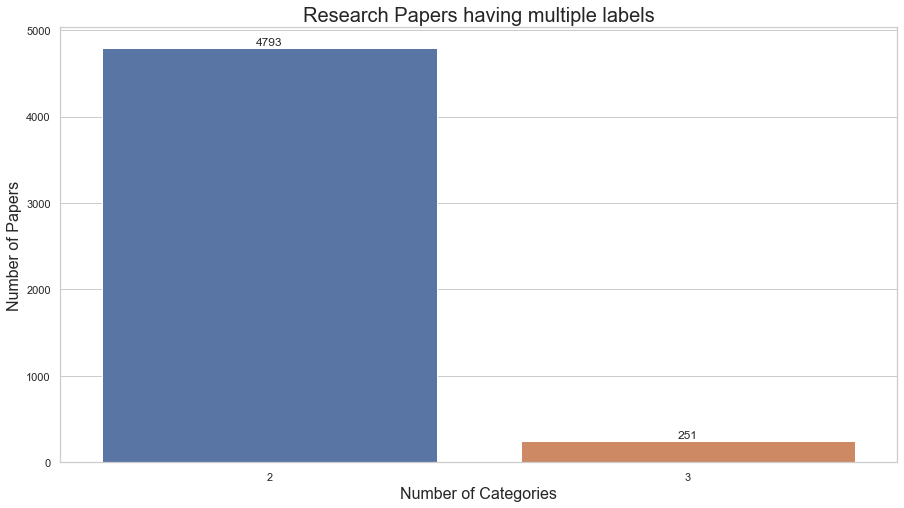

In [9]:
rowSums = train_respapers.iloc[:,2:].sum(axis=1)

multiLabel_counts = rowSums.value_counts().iloc[1:]

plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Research Papers having multiple labels", fontsize=20)
plt.ylabel('Number of Papers', fontsize=16)
plt.xlabel('Number of Categories', fontsize=16)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In the above plot, I am trying show the no. of records having more than one categories where 4793 records have 2 categories and 251 records have 3 categories

# Step 2 : Data Preprocessing

I am performing below data preprocessing for input label which is ' **ABSTRACT** ':

- Remove Punctuation
- Decontracting the text

In [10]:
# Load the regular expression library and spacy library
import re
# Remove punctuation
def remove_punctuation(text):
    text = re.sub('[,\.!?]', '', text)
    return text

# decontract the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    #text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [11]:
#calls the below functions to pre-process the "ABSTRACT" field
#decontracting the text()
train_respapers['ABSTRACT'] = train_respapers['ABSTRACT'].map(lambda com : clean_text(com))

#remove_punctuation()
train_respapers['ABSTRACT'] = train_respapers['ABSTRACT'].apply(lambda x: remove_punctuation(x))

# Print out the first rows of papers
train_respapers.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,predictive models allow subject-specific infer...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,rotation invariance and translation invariance...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,we introduce and develop the notion of spheric...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,the stochastic landau--lifshitz--gilbert (llg)...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,fourier-transform infra-red (ftir) spectra of ...,1,0,0,1,0,0


In [12]:
#printing the label values
research_labels = train_respapers[["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]]
research_labels_val=research_labels.values
print(research_labels_val)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [1 0 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]]


# Step 3: Prepare the Data

- Splitting the dataset
- Tokenizing the text with texts_to_sequence to transform words to numbers 
- Using Pad_sequences to ensure all the vectors are of same length
- Creating the embedding matrix with pre-trained word embedding GloVe

In [13]:
#splitting the data set into 30 and 70 ratio
X_train, X_test, y_train, y_test = train_test_split(
train_respapers['ABSTRACT'], research_labels_val, test_size=0.3, random_state=1234, shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14680,)
(14680, 6)
(6292,)
(6292, 6)


In [14]:
#Split the text to tokens, using most 5000 frequent words and max len to 200
tokenizer = Tokenizer(num_words=5000,lower=True)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("Vocabulary size is ",vocab_size)

Vocabulary size is  47336


In [15]:
#function to create a embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [16]:
#Defining the embedding_dim to 100 for Glove and calling the function to create the 
#embedding matix which goes into the embedding layer
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
     glovepath_file,
     tokenizer.word_index, embedding_dim)
print('found %s word vectors' % len(embedding_matrix))

found 47336 word vectors


# Step 4: Build the Model

- I am creating the model with configurable parameter of pre-training embedding true or false

- Creating the sequential model with

  - Single LSTM layer with 0.2 of dropout to prevent the overfitting
  - Dense layer with 6 outputs (6labels) with Sigmoid activation because my output is binary(0 or 1)

In [17]:
# function that defines the model
from keras import Sequential, Model
from keras.layers import Embedding,LSTM, GlobalMaxPool1D,Conv1D,Bidirectional
from keras.optimizers import Adam, SGD
def get_model(pretrainedembedding):
    model = Sequential()
    if(pretrainedembedding==True):
        model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable=False ,input_length=maxlen))
      
    else:
        model.add(Embedding(vocab_size, embedding_dim ,input_length=maxlen))
        
    #model.add(Dropout(0.2))
    #model.add(LSTM(128,name='lstm_layer',dropout=0.6))
    model.add(LSTM(128,name='lstm_layer',dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='sigmoid'))
    return model
   

- I have defined the callback function to save the best model when validation loss is less
- I am using 'binary_crossentropy' as i am classifying the multiple labels as my loss function with accuracy metric

In [18]:
#function to fit the model 
from keras.callbacks import ModelCheckpoint
def fit_model(model,path,opt):
    cm_callback = ModelCheckpoint(path, save_best_only = True, monitor = 'val_loss', verbose = 1)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    history=model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2,
                  callbacks=[cm_callback],validation_data=(X_test, y_test))
    return(history)

In [19]:
#getting the model for both with and without pre-trained embedding
model_without_pretrainedEmb = get_model(pretrainedembedding=False)
model_pretrainedEmb = get_model(pretrainedembedding=True)

print(model_pretrainedEmb.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          4733600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 4,851,622
Trainable params: 118,022
Non-trainable params: 4,733,600
_________________________________________________________________
None


# Step 5: Train the Model

Defines below three function:

- Evaluate the model against the test data
- To calculate the confusion matrix
- Plot the metrics (loss vs epoch) and (accuracy vs epoch) for train and test data

In [20]:
# takes path and message as the parameters to save the model and print the custom message
import keras
def evaluate(path,msg):
    lstm_model = keras.models.load_model(path)
    test_evaluate = lstm_model.evaluate(X_test, y_test, verbose=1)
    print("Research Papers Test Score :" +msg, test_evaluate[0])
    print("Research Papers Test Accuracy :" +msg, test_evaluate[1])

In [21]:
# takes path and message as the parameters to save the model and print the custom message
from sklearn.metrics import multilabel_confusion_matrix,classification_report
def confusion_matrix(path,msg):
    lstm_model = keras.models.load_model(path)
    Y_pred = lstm_model.predict(X_test)
    Y_pred  = np.where(Y_pred > 0.5, 1, 0)
    print('Confusion Matrix of - ',msg)
    target_names = ['Computer Science', 'Physics', 'Mathematics','Statistics','Quantitative Biology','Quantitative Finance']
    confusionmatrix=multilabel_confusion_matrix(y_test, Y_pred)
    print(confusionmatrix)
    print('Classification Report')
    print(classification_report(y_test, Y_pred, target_names=target_names,zero_division=0))
    print("confusion matrix function")

In [22]:
# takes history of the fitted model and message as the parameters 
import matplotlib.pyplot as plt
def plotmetrics(history,msg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('model accuracy - '+msg)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss - '+msg)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


**Fit Evaluate the model without Pre-trained word Embedding with adam optimizer**

In [23]:

ModelWithoutPretrainEmb_his=fit_model(model_without_pretrainedEmb,modelpath_withoutPretrainEmb,'adam')


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpvzugmxze.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpvzugmxze.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
367/367 [==============================] - 50s 105ms/step - loss: 0.4663 - accuracy: 0.3408 - val_loss: 0.4345 - val_accuracy: 0.4036

Epoch 00001: val_loss improved from inf to 0.43450, saving model to ..\NLPCourseWork\ModelWithoutPretrainEmb.hdf5
Epoch 2/10
367/367 [==============================] - 39s 107ms/step - loss: 0.4338 - accuracy: 0.4200 - val_loss: 0.4300 - val_accuracy

In [24]:
print("The path of the saved model is "+modelpath_withoutPretrainEmb)
evaluate(modelpath_withoutPretrainEmb,"(Model without Pretrained Embedding)")
confusion_matrix(modelpath_withoutPretrainEmb,"for model without pretrained embedding")

The path of the saved model is ..\NLPCourseWork\ModelWithoutPretrainEmb.hdf5
197/197 [==============================] - 7s 31ms/step - loss: 0.2583 - accuracy: 0.7670
Research Papers Test Score :(Model without Pretrained Embedding) 0.2582894265651703
Research Papers Test Accuracy :(Model without Pretrained Embedding) 0.7670057415962219
Confusion Matrix of -  for model without pretrained embedding
[[[2979  700]
  [ 375 2238]]

 [[4252  230]
  [ 352 1458]]

 [[4401  233]
  [ 463 1195]]

 [[4667   92]
  [1437   96]]

 [[6114    0]
  [ 177    1]]

 [[6216    0]
  [  76    0]]]
Classification Report
                      precision    recall  f1-score   support

    Computer Science       0.76      0.86      0.81      2613
             Physics       0.86      0.81      0.83      1810
         Mathematics       0.84      0.72      0.77      1658
          Statistics       0.51      0.06      0.11      1533
Quantitative Biology       1.00      0.01      0.01       178
Quantitative Finance     

I have displayed the outcome in confusion matrix with the labels. 2238 are detected as computer science, 1458 as Physics, 1195 as matematics, 96 as statistics out of 6292 records. But unable to recongnize the labels with "Quantitative biology" and "Quantitative Finance". Below graph shows that loss is reducing and accuracy is increasing with overfit in the data.

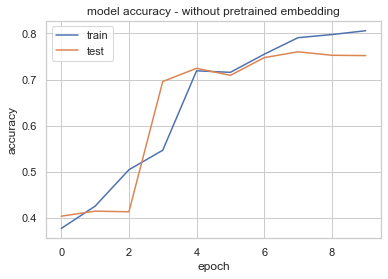

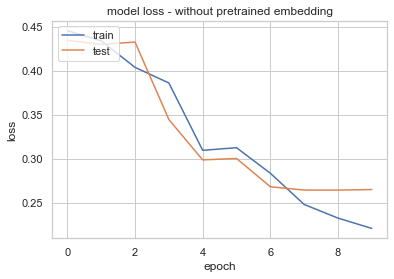

In [25]:
plotmetrics(ModelWithoutPretrainEmb_his,"without pretrained embedding")

**Fit and Evaluate the model with Pre-trained word Embedding(glove) and optimizers(adam & SGD)**

running the model with pretrained word emedding and sgd optimizer
Epoch 1/10
367/367 [==============================] - 31s 81ms/step - loss: 0.6469 - accuracy: 0.3590 - val_loss: 0.5199 - val_accuracy: 0.4029

Epoch 00001: val_loss improved from inf to 0.51995, saving model to ..\NLPCourseWork\ModelWithPretrainEmb.hdf5
Epoch 2/10
367/367 [==============================] - 28s 76ms/step - loss: 0.4914 - accuracy: 0.3992 - val_loss: 0.4456 - val_accuracy: 0.4029

Epoch 00002: val_loss improved from 0.51995 to 0.44560, saving model to ..\NLPCourseWork\ModelWithPretrainEmb.hdf5
Epoch 3/10
367/367 [==============================] - 29s 78ms/step - loss: 0.4465 - accuracy: 0.4036 - val_loss: 0.4362 - val_accuracy: 0.4029

Epoch 00003: val_loss improved from 0.44560 to 0.43625, saving model to ..\NLPCourseWork\ModelWithPretrainEmb.hdf5
Epoch 4/10
367/367 [==============================] - 29s 78ms/step - loss: 0.4409 - accuracy: 0.3978 - val_loss: 0.4335 - val_accuracy: 0.4029

Epoch 00004: 

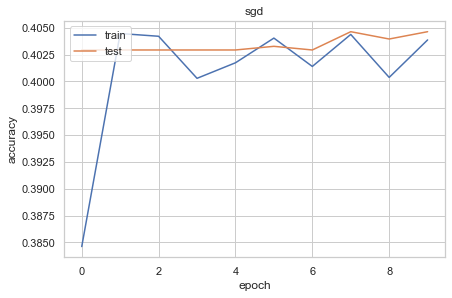

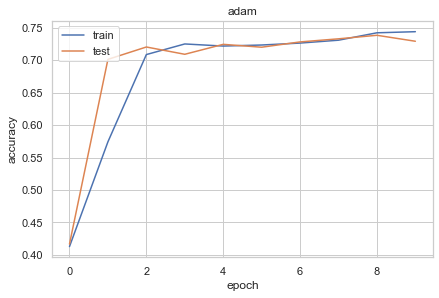

In [26]:
from matplotlib import pyplot
optimizer=["sgd", "adam"]
j=0
for i in optimizer:
    print("running the model with pretrained word emedding and "+i+" optimizer")
    
    plot_no = 420 + (j+1)
    pyplot.figure(figsize=(15,20))
    pyplot.subplot(plot_no)
    ModelWithPretrainEmb_his=fit_model(model_pretrainedEmb,modelpath_withPretrainEmb,i)
    pyplot.plot(ModelWithPretrainEmb_his.history['accuracy'], label='train')
    pyplot.plot(ModelWithPretrainEmb_his.history['val_accuracy'], label='test')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    pyplot.title(i)
    j+=1
pyplot.show()    

In [27]:
print("The path of the saved model is "+modelpath_withPretrainEmb)
evaluate(modelpath_withPretrainEmb,"(Model with Pretrained Embedding)")
confusion_matrix(modelpath_withPretrainEmb,"for model with pretrained embedding")

The path of the saved model is ..\NLPCourseWork\ModelWithPretrainEmb.hdf5
197/197 [==============================] - 6s 29ms/step - loss: 0.2075 - accuracy: 0.7516
Research Papers Test Score :(Model with Pretrained Embedding) 0.20752795040607452
Research Papers Test Accuracy :(Model with Pretrained Embedding) 0.751589298248291
Confusion Matrix of -  for model with pretrained embedding
[[[3158  521]
  [ 420 2193]]

 [[4326  156]
  [ 349 1461]]

 [[4372  262]
  [ 432 1226]]

 [[4404  355]
  [ 481 1052]]

 [[6112    2]
  [ 173    5]]

 [[6216    0]
  [  76    0]]]
Classification Report
                      precision    recall  f1-score   support

    Computer Science       0.81      0.84      0.82      2613
             Physics       0.90      0.81      0.85      1810
         Mathematics       0.82      0.74      0.78      1658
          Statistics       0.75      0.69      0.72      1533
Quantitative Biology       0.71      0.03      0.05       178
Quantitative Finance       0.00      

I have displayed the outcome in confusion matrix with the labels. 2193 are detected as computer science, 1461 as Physics, 1226 as matematics, 1052 as statistics out of 6292 records and 5 for "biology". But unable to recongnize the labels with "Quantitative Finance". Below graph shows that loss is reducing and accuracy is increasing with not much overfit in the data.

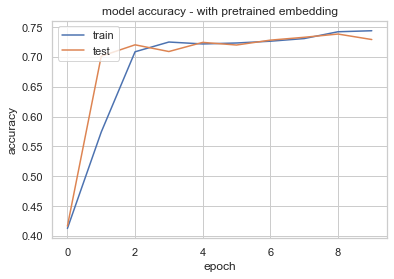

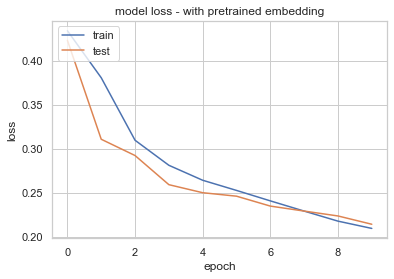

In [28]:
plotmetrics(ModelWithPretrainEmb_his,"with pretrained embedding")

# Step 6: Applying the trained model on unseen test data

In [33]:

test_respapers = pd.read_csv('C:/Users/priyanka/OneDrive - University of Surrey/NLPCourseWork/ResearchPapersDataset/test.csv')
#Remove punctuation
#decontracting the text()
test_respapers['ABSTRACT'] = test_respapers['ABSTRACT'].map(lambda com : clean_text(com))

#remove_punctuation()
test_respapers['ABSTRACT'] = test_respapers['ABSTRACT'].apply(lambda x: remove_punctuation(x))

# Print out the first rows of papers
print(test_respapers.head())

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(test_respapers['ABSTRACT'])

X_train = tokenizer.texts_to_sequences(test_respapers['ABSTRACT'])
maxlen = 200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
lstm_model = keras.models.load_model(modelpath_withPretrainEmb)
Y_pred = lstm_model.predict(X_train)
Y_pred  = np.where(Y_pred > 0.5, 1, 0)
print(Y_pred[1])


      ID                                              TITLE  \
0  20973  Closed-form Marginal Likelihood in Gamma-Poiss...   
1  20974  Laboratory mid-IR spectra of equilibrated and ...   
2  20975         Case For Static AMSDU Aggregation in WLANs   
3  20976  The $Gaia$-ESO Survey: the inner disk intermed...   
4  20977  Witness-Functions versus Interpretation-Functi...   

                                            ABSTRACT  
0  we present novel understandings of the gamma-p...  
1  meteorites contain minerals from solar system ...  
2  frame aggregation is a mechanism by which mult...  
3  milky way open clusters are very diverse in te...  
4  proving that a cryptographic protocol is corre...  
[1 0 0 0 0 0]


In [34]:
myPreds= np.vstack(Y_pred)
print(myPreds[1])

[1 0 0 0 0 0]


In [35]:
for i, col in enumerate(["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]):
    test_respapers[col] = myPreds[:, i]

In [36]:
test_respapers.drop("ABSTRACT", axis=1).to_csv("submission_one.csv", index=False)

**Conclusion :**

- I have experiemented with below two variations

   - Building the model without pre-trained word embedding gives an accuracy of 76% with reduction in loss and increase in accuracy for both train and test data , but its unable to
     predict the labes that are "Quantitative Biology" and "Quantitative finance" with very low precision and recall.
   - Building the model with pre-trained word embedding gives an accuracy of 75% with reduction in loss and increase in accuracy  for both test and train data , but its unable to predict labes that are "Quantitative Biology" and "Quantitative finance" with very low precision and recall.
   - Adam optimizer performs very well where as SGD has a constant accuracy with no learning
   
   
- In the next notebook i will be building the model with :
   - Bi-directional LSTM
   - Adding the activation layer (RELU) and Pooling(Global max Pool)
   - Experiements on the learning rate
   
  